In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import re
import pickle
import string

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# NLP library
from nltk.tokenize import word_tokenize


In [2]:
from numpy.random import seed
seed(42)

In [3]:
df = pd.read_csv('./data/EngSpa.csv')

In [4]:
df.head()

,Unnamed: 0,eng,spa,eng_len,spa_len
0,10910,a bird has wings,los pájaros tienen alas,16,23
1,10911,a bird has wings,un pájaro tiene alas,16,20
2,10912,a cab is waiting,hay un taxi esperando,16,21
3,10914,a deal is a deal,un trato es un trato,16,20
4,10915,a dog is barking,un perro está ladrando,16,22


In [5]:
df.drop(columns=['Unnamed: 0', 'eng_len', 'spa_len'], inplace=True)
df.head()

,eng,spa
0,a bird has wings,los pájaros tienen alas
1,a bird has wings,un pájaro tiene alas
2,a cab is waiting,hay un taxi esperando
3,a deal is a deal,un trato es un trato
4,a dog is barking,un perro está ladrando


In [17]:
#Converting to list for the model
data = df.values.tolist()

# Examining the first 5 rows
data[:5]

[['a bird has wings', 'los pájaros tienen alas'],
 ['a bird has wings', 'un pájaro tiene alas'],
 ['a cab is waiting', 'hay un taxi esperando'],
 ['a deal is a deal', 'un trato es un trato'],
 ['a dog is barking', 'un perro está ladrando']]

In [12]:
data_s = pd.DataFrame(data[0:18000,0])

TypeError: list indices must be integers or slices, not tuple

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

In [9]:
# vectorizing text with 1,2 ngrams and 10,000 max features instead of 20,000 from previous notebook
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=10_000)
data_s_tvec = tvec.fit_transform(data_s)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
# removing most common english words from text
df_tvec['eng'] = [[eng for token in token_list if token not in stopwords.words('english')] for token_list in df_tvec['eng']]

In [8]:
# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

# Setting the amount of data points to use
n = 18000

for line in data[:n]:
    # Defining an input document and a target document
    input_doc, target_doc = line[0], line[1]
    
    # Appending each input sentence to input_docs
    input_docs.append(input_doc)
    
    # Formatting target documents
    # Splitting words from punctuation  
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    # Adding <START> and <END> tags
    target_doc = '<START> ' + target_doc + ' <END>'
    # Appending each formated target to target documents
    target_docs.append(target_doc)
  
    # Splitting each sentence into words and adding to vocabulary
    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
        if token not in input_tokens:
            input_tokens.add(token)
    
    for token in target_doc.split():
        if token not in target_tokens:
            target_tokens.add(token)

In [9]:
#Deleting some objects to free up memory since the epoch runs below run into memory issues
del data
del df

In [10]:
print(input_docs[0])
print(target_docs[0])

a dog has four legs
<START> un perro tiene cuatro patas <END>


In [81]:
# Creating a sorted list of all input tokens and target tokens
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Saving the length of vocabulary sets as variables. Encoder and Decoder
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Finding the maximum length of an input sentence and target sentence
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [82]:
# Print some key dimensions - these need to be used later for enabling model-continued training as well as getting translations
print(f'Number of Encoder Tokens: {num_encoder_tokens}')
print(f'Number of Decoder Tokens: {num_decoder_tokens}')
print(f'Maximum Encoder Sequence Length: {max_encoder_seq_length}')
print(f'Maximum Decoder Sequence Length: {max_decoder_seq_length}')

Number of Encoder Tokens: 5134
Number of Decoder Tokens: 8263
Maximum Encoder Sequence Length: 8
Maximum Decoder Sequence Length: 17


In [83]:
# Creating four dictionaries
input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

# Creating the reverse 
reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

In [84]:
import pickle

with open('./data/rtfd.p', 'wb') as fp:
    pickle.dump(reverse_target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/tfd.p', 'wb') as fp:
    pickle.dump(target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/rifd.p', 'wb') as fp:
    pickle.dump(reverse_input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/ifd.p', 'wb') as fp:
    pickle.dump(input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [85]:
# Checking English index and word dictionary
first2pairs = {k: reverse_input_features_dict[k] for k in list(reverse_input_features_dict)[:2]}
first2pairs

{0: 'a', 1: 'aback'}

In [86]:
# Checking English word and index dictionary
first2pairs = {k: input_features_dict[k] for k in list(input_features_dict)[:2]}
first2pairs

{'a': 0, 'aback': 1}

In [87]:
# Checking Spanish index and word dictionary
firstfewpairs = {k: reverse_target_features_dict[k] for k in list(reverse_target_features_dict)[2:8]}
firstfewpairs

{2: 'a',
 3: 'abajo',
 4: 'abandona',
 5: 'abandonada',
 6: 'abandonado',
 7: 'abandonamos'}

In [88]:
# Checking Spanish word and index dictionary
firstfewpairs = {k: target_features_dict[k] for k in list(target_features_dict)[2:8]}
firstfewpairs

{'a': 2,
 'abajo': 3,
 'abandona': 4,
 'abandonada': 5,
 'abandonado': 6,
 'abandonamos': 7}

In [89]:
# Creating empty matricies for input data
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [90]:
print(f'Encoder Input Data Shape: {encoder_input_data.shape}')
print(f'Decoder Input Data Shape: {decoder_input_data.shape}')
print(f'Decoder Target Data Shape: {decoder_target_data.shape}')

Encoder Input Data Shape: (18000, 8, 5134)
Decoder Input Data Shape: (18000, 17, 8263)
Decoder Target Data Shape: (18000, 17, 8263)


In [91]:
# This block of code sets up our data for input to the neural net.

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):

    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # Assigning 1.0 for the current line, timestep, & word in encoder_input_data:
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.0
        # Potential Conditional Statement

    for timestep, token in enumerate(target_doc.split()):
        # Assigning 1.0 for same in decoder_input_data
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.0
        if timestep > 0:
            
            # Setting the decoder target data for 1 previous timestep
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.0

In [94]:
#Checking sample word in matrix
np.argmax(encoder_input_data[10])

119

In [95]:
#Confirming word was read correctly
reverse_input_features_dict[119]

'all'

In [96]:
print(num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

5134 8263 8 17


## LSTM MODEL BUILD TO START FROM HERE

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.backend import manual_variable_initialization #was added to ensure model can be loaded correctly later
manual_variable_initialization(True)

import os

In [27]:
tf.random.set_seed(42)

## Defining the model Structure

In [28]:
#Defining the model structure
latent_dim = 256 ### Would have liked to increase this, but memory and run-time issues caused me to cap

# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [29]:
epochs = 25
batch_size = 128

#callback = EarlyStopping(monitor='val_accuracy', patience=4) #Was turned off since model was improving gradually

training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

#Turn checkpoint on so that interim model run results can be used if system crashes, saved every 5 epochs
model_checkpoint= ModelCheckpoint('./models/endspan{epoch:02d}.h5',period=5,save_weights_only=False)

history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/25
113/113 [==============================] - 105s 894ms/step - loss: 2.1387 - accuracy: 0.7031 - val_loss: 2.1112 - val_accuracy: 0.7191
Epoch 2/25
113/113 [==============================] - 96s 849ms/step - loss: 1.9168 - accuracy: 0.7421 - val_loss: 2.1155 - val_accuracy: 0.7210
Epoch 3/25
113/113 [==============================] - 97s 861ms/step - loss: 1.8876 - accuracy: 0.7438 - val_loss: 2.1294 - val_accuracy: 0.7224
Epoch 4/25
113/113 [==============================] - 96s 852ms/step - loss: 1.8777 - accuracy: 0.7447 - val_loss: 2.1093 - val_accuracy: 0.7230
Epoch 5/25
113/113 [==============================] - 99s 876ms/step - loss: 1.8550 - accuracy: 0.7480 - val_loss: 2.0883 - val_accuracy: 0.7324
Epoch 6/25
113/113 [==============================] - 90s 800ms/step - loss: 1.8261 - accuracy: 0.7534 - val_loss: 2.0585 - val_accuracy: 0.7365
Epoch 7/25
113/113 [==============================] - 90s 800ms/step - loss: 1.7891 - accuracy: 0.7591 - val_loss: 2.0378 - val_a

In [30]:
#training_model = load_model('training_model_v2.h5')

NameError: name 'load_model' is not defined

In [42]:
epochs = 25
history2 = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/25
113/113 [==============================] - 98s 868ms/step - loss: 1.3015 - accuracy: 0.8161 - val_loss: 1.7564 - val_accuracy: 0.7800
Epoch 2/25
113/113 [==============================] - 96s 850ms/step - loss: 1.2822 - accuracy: 0.8185 - val_loss: 1.7540 - val_accuracy: 0.7815
Epoch 3/25
113/113 [==============================] - 97s 858ms/step - loss: 1.2632 - accuracy: 0.8209 - val_loss: 1.7525 - val_accuracy: 0.7826
Epoch 4/25
113/113 [==============================] - 97s 863ms/step - loss: 1.2445 - accuracy: 0.8236 - val_loss: 1.7412 - val_accuracy: 0.7834
Epoch 5/25
113/113 [==============================] - 98s 868ms/step - loss: 1.2265 - accuracy: 0.8260 - val_loss: 1.7371 - val_accuracy: 0.7814
Epoch 6/25
113/113 [==============================] - 98s 868ms/step - loss: 1.2059 - accuracy: 0.8288 - val_loss: 1.7286 - val_accuracy: 0.7849
Epoch 7/25
113/113 [==============================] - 95s 838ms/step - loss: 1.1912 - accuracy: 0.8307 - val_loss: 1.7282 - val_ac

In [60]:
epochs = 5
history3 = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/5
113/113 [==============================] - 98s 866ms/step - loss: 0.9218 - accuracy: 0.8740 - val_loss: 1.6873 - val_accuracy: 0.7930
Epoch 2/5
113/113 [==============================] - 92s 816ms/step - loss: 0.9112 - accuracy: 0.8761 - val_loss: 1.6799 - val_accuracy: 0.7964
Epoch 3/5
113/113 [==============================] - 91s 805ms/step - loss: 0.8998 - accuracy: 0.8779 - val_loss: 1.6775 - val_accuracy: 0.7953
Epoch 4/5
113/113 [==============================] - 90s 795ms/step - loss: 0.8890 - accuracy: 0.8803 - val_loss: 1.6806 - val_accuracy: 0.7958
Epoch 5/5
113/113 [==============================] - 90s 795ms/step - loss: 0.8796 - accuracy: 0.8816 - val_loss: 1.6793 - val_accuracy: 0.7944


In [73]:
#Saving the model so we can use later
#tf.saved_model.save(training_model, './models/')
training_model.save('./models/training_model_gcp.h5')


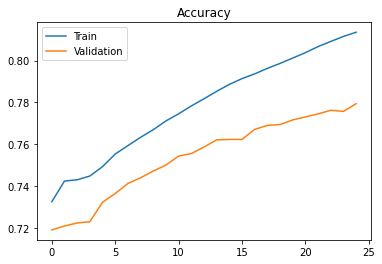

In [39]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

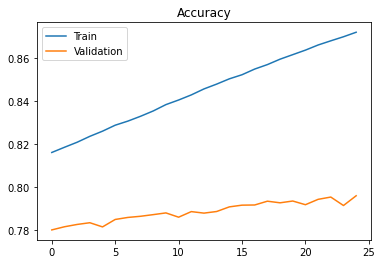

In [44]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

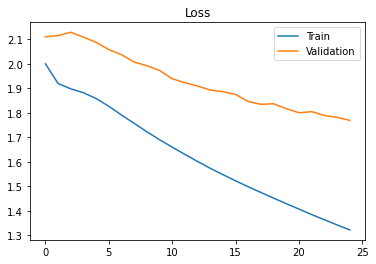

In [40]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

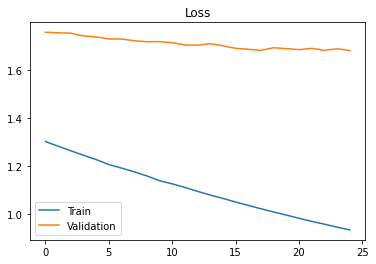

In [45]:
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

In [61]:
from tensorflow.keras.models import Model, load_model

#training_model = load_model('training_model_v2.h5')

encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [62]:
def string_to_matrix(user_input):
    '''This function takes in a string and outputs the corresponding matrix'''
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for timestep, token in enumerate(tokens):
        if token in input_features_dict:
            user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

In [63]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5134)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 8263)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 5520384     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  8724480     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [64]:
def decode_sequence(test_input):
    '''This function takes in a sentence and returns the decoded sentence'''
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(string_to_matrix(test_input))

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    # Sampling loop for a batch of sequences
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        # Run the decoder model to get possible output tokens (with probabilities) & states
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Choose token with highest probability and append it to decoded sentence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop token.
        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [hidden_state, cell_state]

    return decoded_sentence

In [72]:
# Example decoded sentence
decode_sequence('what is your name')

' qué es tu <END>'

In [70]:
# Example decoded sentence
decode_sequence('it is hot today')

' hoy hace <END>'

In [71]:
# Example decoded sentence
decode_sequence('my wife is here')

' mi esposa es <END>'